In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# Matplotlib 한글 폰트 설정 (Windows - 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("--- 우수 고객 유지 및 일반 고객 육성 시각화 시작 ---")

--- 우수 고객 유지 및 일반 고객 육성 시각화 시작 ---


In [3]:
# 1. 데이터 읽기 및 전처리
df = pd.read_csv('store_data.csv', parse_dates=['주문 일자'])
snapshot_date = df['주문 일자'].max() + pd.Timedelta(days=1)

# 2. RFM 계산
rfm_df = df.groupby('고객번호').agg(
    Recency=('주문 일자', lambda x: (snapshot_date - x.max()).days),
    Frequency=('주문 번호', 'nunique'),
    Monetary=('매출', 'sum')
).reset_index()

# 3. 세그먼트 분류 (확정된 기준)
R_CUTOFF = 173
F_CUTOFF = 9
M_CUTOFF = 6547279

def segment_customer(row):
    if row['Recency'] >= R_CUTOFF: return '이탈 위험'
    elif (row['Frequency'] >= F_CUTOFF) and (row['Monetary'] >= M_CUTOFF): return '우수'
    else: return '일반'

rfm_df['Segment'] = rfm_df.apply(segment_customer, axis=1)

# 데이터 병합
df_merged = df.merge(rfm_df[['고객번호', 'Segment']], on='고객번호', how='left')

# 그룹별 데이터 분리
loyal_df = df_merged[df_merged['Segment'] == '우수']
general_df = df_merged[df_merged['Segment'] == '일반']

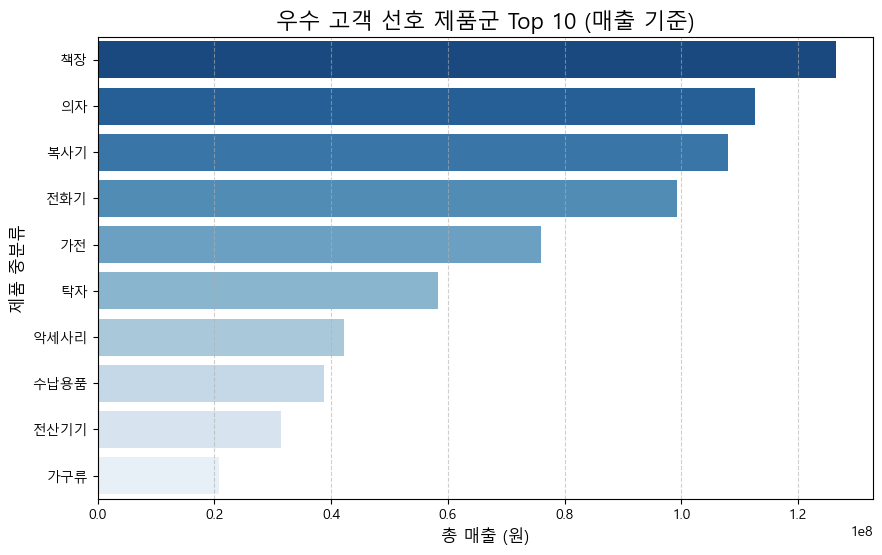

In [4]:
# =========================================================
# 시각화 1: 우수 고객이 가장 사랑하는 제품군 Top 10 (매출 기준)
# =========================================================
loyal_top_categories = loyal_df.groupby('제품 중분류')['매출'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=loyal_top_categories.values, y=loyal_top_categories.index, palette='Blues_r')
plt.title('우수 고객 선호 제품군 Top 10 (매출 기준)', fontsize=16)
plt.xlabel('총 매출 (원)', fontsize=12)
plt.ylabel('제품 중분류', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

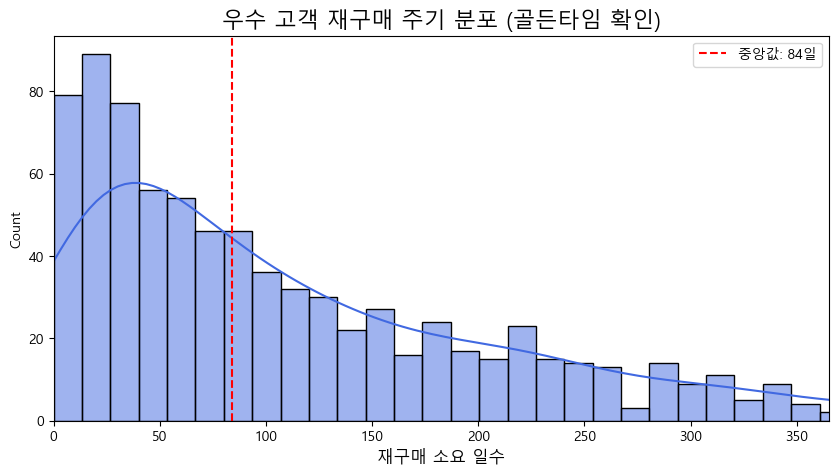

In [5]:
# =========================================================
# 시각화 2: 우수 고객의 재구매 주기 분포 (골든타임)
# =========================================================
loyal_orders = loyal_df[['고객번호', '주문 번호', '주문 일자']].drop_duplicates().sort_values(['고객번호', '주문 일자'])
loyal_orders['Prev_Order_Date'] = loyal_orders.groupby('고객번호')['주문 일자'].shift(1)
loyal_orders['Days_Since_Prev'] = (loyal_orders['주문 일자'] - loyal_orders['Prev_Order_Date']).dt.days
median_interval = loyal_orders['Days_Since_Prev'].median()

plt.figure(figsize=(10, 5))
sns.histplot(loyal_orders['Days_Since_Prev'].dropna(), bins=50, kde=True, color='royalblue')
plt.axvline(median_interval, color='red', linestyle='--', label=f'중앙값: {median_interval:.0f}일')
plt.title('우수 고객 재구매 주기 분포 (골든타임 확인)', fontsize=16)
plt.xlabel('재구매 소요 일수', fontsize=12)
plt.xlim(0, 365)
plt.legend()
plt.show()

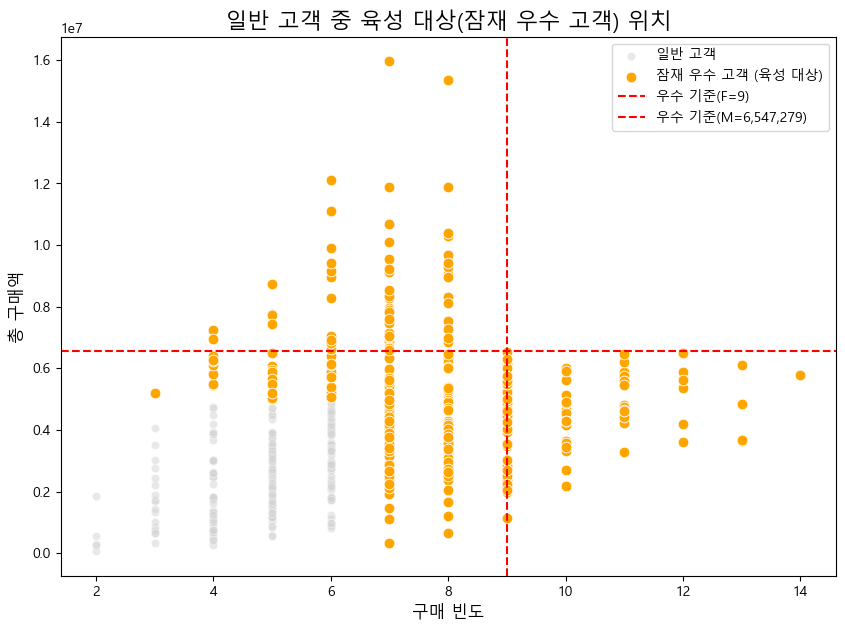

In [6]:
# =========================================================
# 시각화 3: 일반 고객 중 '잠재 우수 고객' 식별 (산점도)
# =========================================================
# 육성 대상 기준 (예: 빈도 7회 이상 OR 매출 500만원 이상)
POTENTIAL_F = 7
POTENTIAL_M = 5000000
rfm_general = rfm_df[rfm_df['Segment'] == '일반']
potentials = rfm_general[(rfm_general['Frequency'] >= POTENTIAL_F) | (rfm_general['Monetary'] >= POTENTIAL_M)]

plt.figure(figsize=(10, 7))
# 전체 일반 고객 (회색)
sns.scatterplot(data=rfm_general, x='Frequency', y='Monetary', color='lightgrey', alpha=0.5, label='일반 고객')
# 잠재 우수 고객 (주황색 강조)
sns.scatterplot(data=potentials, x='Frequency', y='Monetary', color='orange', s=60, label='잠재 우수 고객 (육성 대상)')

# 우수 고객 기준선
plt.axvline(F_CUTOFF, color='red', linestyle='--', label=f'우수 기준(F={F_CUTOFF})')
plt.axhline(M_CUTOFF, color='red', linestyle='--', label=f'우수 기준(M={M_CUTOFF:,.0f})')

plt.title('일반 고객 중 육성 대상(잠재 우수 고객) 위치', fontsize=16)
plt.xlabel('구매 빈도', fontsize=12)
plt.ylabel('총 구매액', fontsize=12)
plt.legend()
plt.show()

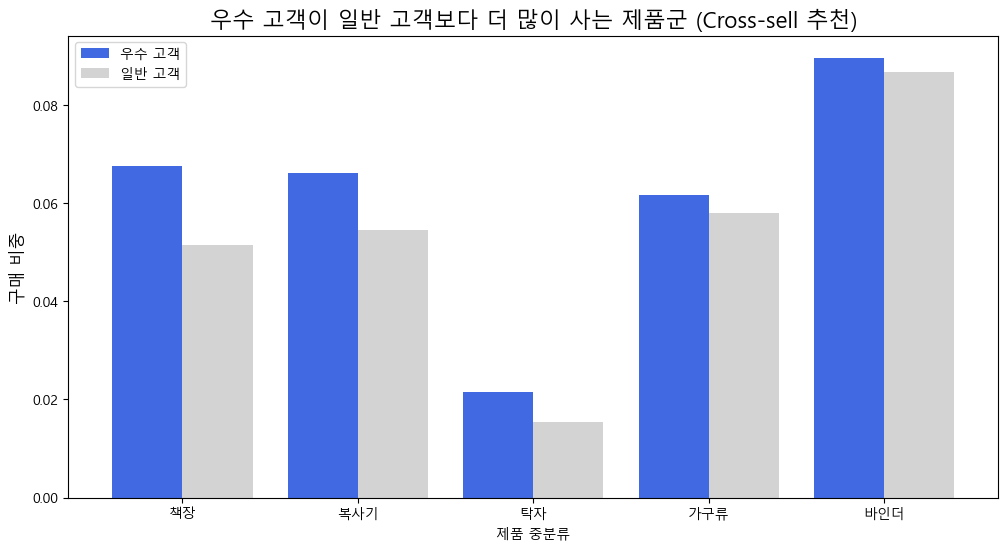

In [7]:
# =========================================================
# 시각화 4: 우수 vs 일반 고객 구매 제품 차이 (교차 판매 포인트)
# =========================================================
loyal_cat_dist = loyal_df['제품 중분류'].value_counts(normalize=True)
general_cat_dist = general_df['제품 중분류'].value_counts(normalize=True)

comp_df = pd.DataFrame({'우수 고객': loyal_cat_dist, '일반 고객': general_cat_dist}).fillna(0)
comp_df['차이(우수-일반)'] = comp_df['우수 고객'] - comp_df['일반 고객']
# 차이가 큰 순서대로 정렬 (우수 고객이 더 많이 사는 제품)
comp_df = comp_df.sort_values('차이(우수-일반)', ascending=False).head(5)

comp_df[['우수 고객', '일반 고객']].plot(kind='bar', figsize=(12, 6), width=0.8, color=['royalblue', 'lightgrey'])
plt.title('우수 고객이 일반 고객보다 더 많이 사는 제품군 (Cross-sell 추천)', fontsize=16)
plt.ylabel('구매 비중', fontsize=12)
plt.xticks(rotation=0)
plt.legend()
plt.show()

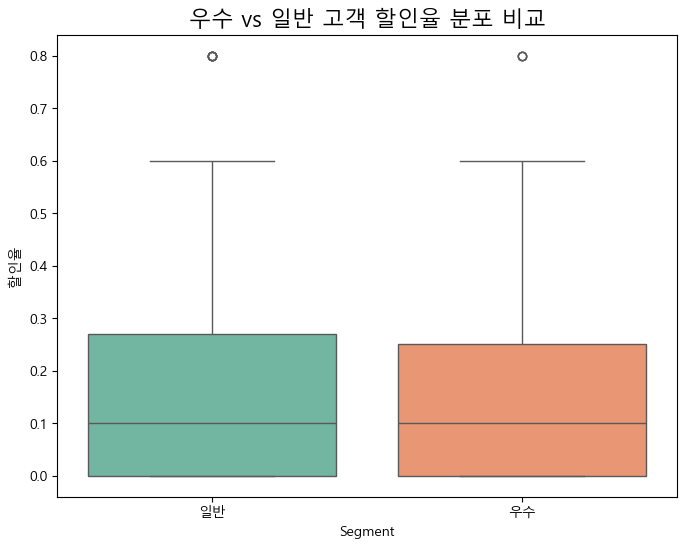

In [8]:
# =========================================================
# 시각화 5: 우수 vs 일반 할인 민감도 비교 (Boxplot)
# =========================================================
plt.figure(figsize=(8, 6))
target_df = df_merged[df_merged['Segment'].isin(['우수', '일반'])]
sns.boxplot(x='Segment', y='할인율', data=target_df, order=['일반', '우수'], palette='Set2')
plt.title('우수 vs 일반 고객 할인율 분포 비교', fontsize=16)
plt.show()